In [1]:
from jaxsnn.channels import synapse as syn

In [2]:
def synapse_dynamics(p: syn.SynapseParameters):
    def dynamics(s, u):
        return syn.dynamics(s, p)

    return dynamics


ampa_dynamics = synapse_dynamics(syn.ampa_parameters)
nmda_dynamics = synapse_dynamics(syn.nmda_parameters)
gaba_dynamics = synapse_dynamics(syn.martinotti_gaba_parameters)

In [3]:
from jaxsnn.base import explicit
from jaxsnn.base.types import ArrayLike
import tree_math


def synapse_projection(p: syn.SynapseParameters):
    def projection(x, u):
        x = syn.transition(w=u, s=x, p=p)
        return x

    return projection


ampa_projection = synapse_projection(syn.ampa_parameters)
nmda_projection = synapse_projection(syn.nmda_parameters)
gaba_projection = synapse_projection(syn.martinotti_gaba_parameters)


@tree_math.struct
class State:
    gaba: syn.SynapseState
    ampa: syn.SynapseState
    nmda: syn.SynapseState


@tree_math.struct
class Parameters:
    gaba: syn.SynapseParameters = syn.martinotti_gaba_parameters
    ampa: syn.SynapseParameters = syn.ampa_parameters
    nmda: syn.SynapseParameters = syn.nmda_parameters


def dynamics(s: State, _):
    return State(
        gaba=gaba_dynamics(s.gaba, _),
        ampa=ampa_dynamics(s.ampa, _),
        nmda=nmda_dynamics(s.nmda, _),
    )


def projection(x, u):
    return State(
        gaba=gaba_projection(x.gaba, u.gaba),
        ampa=ampa_projection(x.ampa, u.ampa),
        nmda=nmda_projection(x.nmda, u.nmda),
    )


def output(x, u):
    return x


equation = explicit.ExplicitConstrainedCDE(
    explicit_terms=dynamics, projection=projection, output=output
)

In [4]:
import jax
from jaxsnn.base import funcutils
import numpy as np

T = 2048
dt = 0.1
stim = np.zeros(T)
stim[1] = 1.0  # add a square pulse

stim = State(ampa=stim, nmda=stim, gaba=stim)

step_fn = explicit.classic_rk4_cde(equation, dt)
integrator = funcutils.controlled_trajectory(step_fn, stim)
integrator = jax.jit(integrator)

In [5]:
s = syn.SynapseState(a=0.0, b=0.0)
s = State(ampa=s, gaba=s, nmda=s)
_, sol = integrator(s)

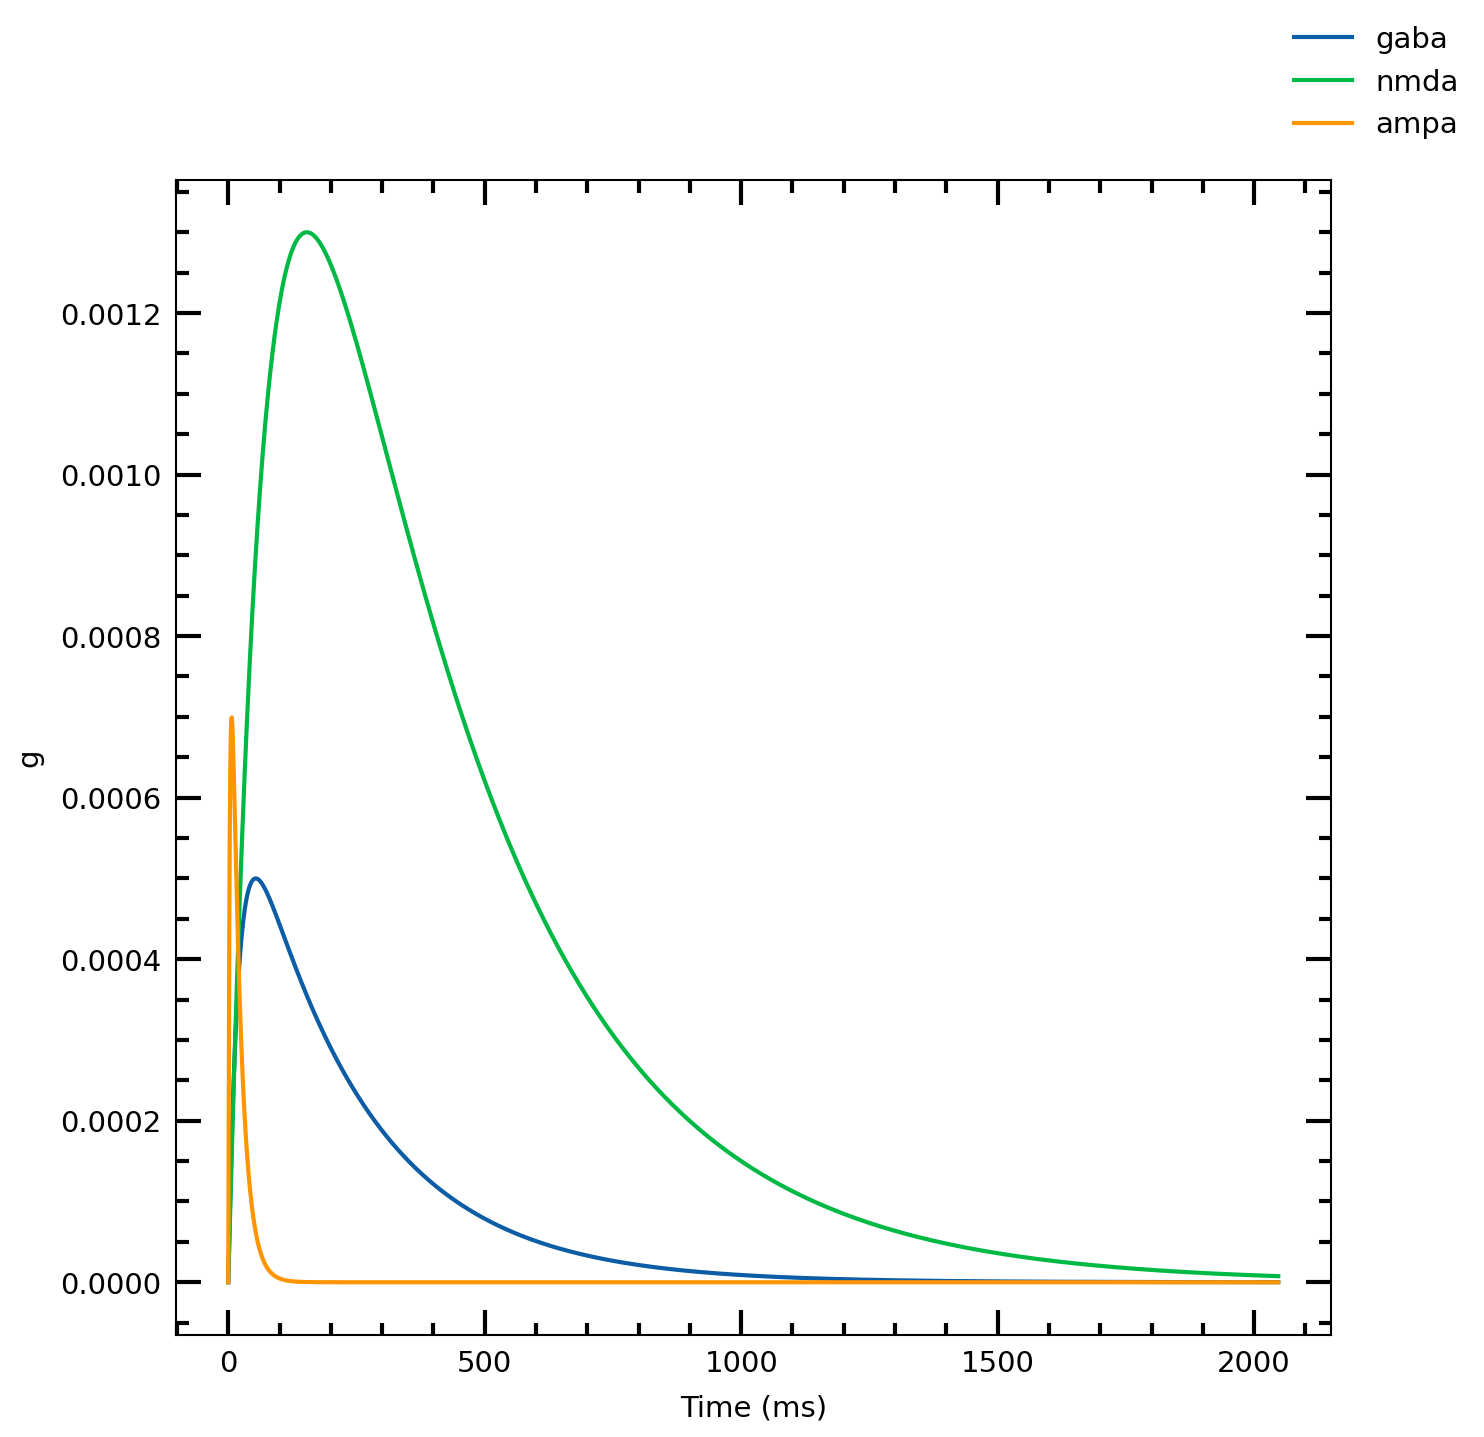

In [6]:
import matplotlib.pyplot as plt

plt.style.use(["science", "notebook", "nature"])

fig, ax = plt.subplots(
    1, 1, sharex=True, figsize=(5, 5), subplot_kw=dict(box_aspect=1), dpi=300
)
ax.plot(syn.g_syn(sol.gaba, syn.martinotti_gaba_parameters), label="gaba")
ax.plot(syn.g_syn(sol.nmda, syn.nmda_parameters), label="nmda")
ax.plot(syn.g_syn(sol.ampa, syn.ampa_parameters), label="ampa")

ax.set_xlabel("Time (ms)")
ax.set_ylabel("g")
fig.legend()

In [7]:
import functools

fn = jax.value_and_grad(functools.partial(funcutils.controlled_trajectory, step_fn))